In [1]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
from bauer.utils.math import softplus_np

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [3]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r'][:1]
n_voxels = [0, 1, 100]
# n_voxels = [0, 100]
natural_space = [False]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)


df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')

r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

  0%|          | 0/315 [00:00<?, ?it/s]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_92577/4006245874.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [4]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-1_trace.netcdf')

In [5]:
n1_evidence_sd = idata.posterior['n1_evidence_sd'].to_dataframe().groupby(['subject', 'n1_evidence_sd_regressors']).mean()
n2_evidence_sd = idata.posterior['n2_evidence_sd'].to_dataframe().groupby(['subject', 'n2_evidence_sd_regressors']).mean()

In [6]:
r2_diff = r2.droplevel('session').unstack(['stimulation_condition'])
r2_diff = r2_diff[('r', 'ips')] - r2_diff[('r', 'vertex')]

In [7]:
n1_evidence_sd_ips = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors'))
n1_evidence_sd_vertex = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors') + n1_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n1_evidence_sd_regressors'))

In [8]:
n2_evidence_sd_ips = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors'))
n2_evidence_sd_vertex = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors') + n2_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n2_evidence_sd_regressors'))

In [9]:
n1_evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)
n2_evidence_sd = pd.concat((n2_evidence_sd_ips, n2_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)

total_evidence_sd = n1_evidence_sd.loc[:, (slice(None), 'n1_evidence_sd')].droplevel(1, 1) + n2_evidence_sd.loc[:, (slice(None), 'n2_evidence_sd')].droplevel(1, 1)

In [10]:
n1_evidence_sd_diff = n1_evidence_sd['ips'] - n1_evidence_sd['vertex']
n2_evidence_sd_diff = n2_evidence_sd['ips'] - n2_evidence_sd['vertex']
total_evidence_sd_diff = (total_evidence_sd['ips'] - total_evidence_sd['vertex']).to_frame('total_evidence_sd')

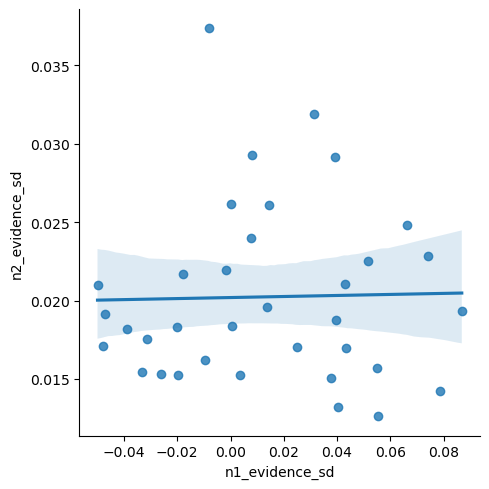

In [11]:
import seaborn as sns
sns.lmplot(data=n1_evidence_sd_diff.join(n2_evidence_sd_diff), x='n1_evidence_sd', y='n2_evidence_sd') 

In [12]:
r2_diff.to_frame('r').join(n1_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10     power
mask n_voxels                                                                
NPCr 0        pearson  35 -0.066874  [-0.39, 0.27]  0.702691  0.226  0.066561
     1        pearson  35 -0.196496   [-0.5, 0.15]  0.257912  0.389  0.206705
     100      pearson  35  0.013653  [-0.32, 0.35]  0.937954  0.211  0.050257

In [13]:
r2_diff.to_frame('r').join(n2_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

n         r          CI95%     p-val   BF10     power
mask n_voxels                                                                
NPCr 0        pearson  35  0.245218   [-0.1, 0.53]  0.155658  0.554  0.299309
     1        pearson  35 -0.069663  [-0.39, 0.27]  0.690890  0.227  0.068028
     100      pearson  35 -0.139768   [-0.45, 0.2]  0.423254  0.286  0.126574

In [14]:
r2_diff.to_frame('r').join(total_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['total_evidence_sd']))

n         r          CI95%     p-val   BF10     power
mask n_voxels                                                                
NPCr 0        pearson  35 -0.030844  [-0.36, 0.31]  0.860379  0.213  0.053138
     1        pearson  35 -0.203808   [-0.5, 0.14]  0.240262  0.408  0.219240
     100      pearson  35 -0.006551  [-0.34, 0.33]  0.970205   0.21  0.049718

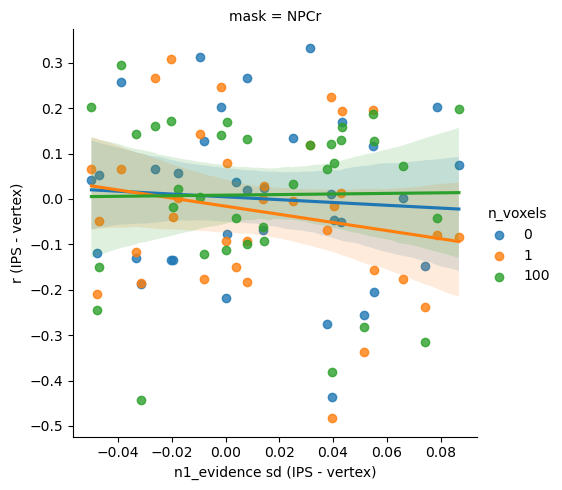

In [15]:
g = sns.lmplot(x='n1_evidence_sd', y='r', data=r2_diff.to_frame('r').join(n1_evidence_sd_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('n1_evidence sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')

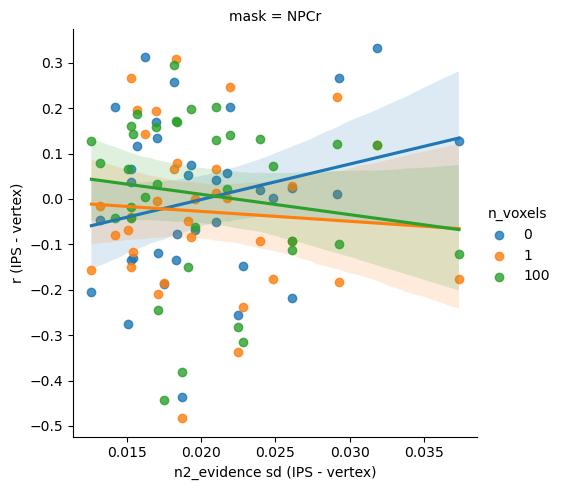

In [16]:
g = sns.lmplot(x='n2_evidence_sd', y='r', data=r2_diff.to_frame('r').join(n2_evidence_sd_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('n2_evidence sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')